# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 01.12.2022

Мягкий дедлайн: 23:59MSK 11.12.2022

Жесткий дедлайн: 23:59MSK 15.12.2022

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

%config InlineBackend.figure_format = 'retina'
sns.set(style='darkgrid', palette='deep')

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

In [6]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [7]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.21708142510276

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [20]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set of objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    index_set = set(np.arange(X.shape[0]))
    pred = np.zeros([num_runs, X.shape[0]])
    error_matrix = np.zeros(num_runs)
    for i in range(num_runs):
        bootstrap_index = np.random.randint(0, X.shape[0], X.shape[0])
        #оставляю индексы, которые не попали в бутстрап
        out_of_bag_index = list(index_set.difference(bootstrap_index))
        #обучаю модель
        reg = regressor.fit(X[bootstrap_index], y[bootstrap_index])
        pred[i][out_of_bag_index] = reg.predict(X[out_of_bag_index]) 
        error_matrix[i] = np.mean((reg.predict(X[out_of_bag_index]) - y[out_of_bag_index])**2)
    #приведу матрицу к виду, где строка - один объект
    pred = np.array(list(zip(*pred)))
    pred = np.where(pred > 0, pred, np.nan)
    error = np.mean(error_matrix)
    bias = np.nanmean((np.nanmean(pred, axis=1) - y)**2)
    variance = np.nanmean(np.nanvar(pred, axis=1))
    return bias, variance, error

$\color{red}{\text{Комментарий от проверяющего:}}$

**Балл:** 3.0

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [10]:
def add_row(dataframe, algorithm_name, algorithm):
    bias, variance, error = algorithm
    dataframe = pd.concat([dataframe, pd.DataFrame([[algorithm_name, bias, variance, error]], 
                                columns=['algorithm', 'bias', 'variance', 'error'])], ignore_index=True)
    return dataframe

In [79]:
bias, variance, error = compute_biase_variance(LinearRegression(), X, y)
result = pd.DataFrame(['LinearRegression', bias, variance, error]).T.rename(columns={
    0: 'algorithm', 
    1: 'bias', 
    2: 'variance', 
    3: 'error'
})

In [80]:
result = add_row(result, 'DecisionTreeRegressor', compute_biase_variance(DecisionTreeRegressor(), X, y))

In [82]:
result = add_row(result, 'RandomForestRegressor', compute_biase_variance(RandomForestRegressor(), X, y))

In [83]:
result

,algorithm,bias,variance,error
0,LinearRegression,23.431925,0.920465,24.689334
1,DecisionTreeRegressor,10.170548,13.041669,23.226175
2,RandomForestRegressor,10.674066,2.26797,12.850093


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__ В итоге получили, что самое большое смещение у линейной регрессии, но при этом у нее самый маленький разброс. У одного дерева достаточное низкое смещение, но большой разброс и поэтому суммарная ошибка тоже достаточно большая. У случайного леса смещение примерно как у дерева, но при этом малый разброс. Это полностью согласуется с тем, что мы обсуждал на семинарах. Линейные модели простые и описывают только линейные зависимости, поэтому они далеки от реальной зависимости и имеют большое смещение. Но при этом веса линейной модели не сильно чувствительны к малым изменениям в исходных данных, поэтому они имеют малый разброс. Дерево, наоборот, сложная модель и она хорошо описывает реальную зависисмость - малое смещение, но дерево очень нестабильное и чувствительно к исходному набору данных, поэтому получили большой разброс. Случайный лес имеет смещение не хуже, чем одно дерево, тк если расписать мат ожидание, то увидим, что смещение композиции деревье не больше, чем у одного дерева. А вот за счет увеличения числа деревьев разброс уменьшается пропорционально. 

$\color{red}{\text{Комментарий от проверяющего:}}$

**Балл:** 1.0

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__ В теории, если отдельные алгоритмы некоррелированы между собой, то разброс после бэггинга уменьшается в N раз, где N - число выборок. Если корреляция есть, то уменьшение разброса будет меньше. В моих эксериментах это выполняется не везде. В линейной модели бэггинг даже увеличил разброс. Это связано с тем, что линейные модели очень похожи друг на друга, тк строятся по похожим выборкам и, как я говорил выше, они не очень чувствительны к изменениям в данных, поэтому бэггинг над линейными моделями работает плохо. Для дерева(глубокого) бэггинг хорошо работает, так как это по сути тот же случайные лес - мы взяли 10 деревьев(такой дефолтный параметр в функции BaggingRegressor) и усреднили ответы по ним. Смещение не увеличилось, а разброс уменьшился, но не в 10 раз, так как все же между деревьями есть корреляция. Для случайного леса получилось, что разброс уменьшился, но при этом смещение увеличилось примерно на такую же величину и в итоге суммарная ошибка осталась на том же уровне. Кажется, случайный лес переобучился и бэггинг для него это не очень хорошая затея

In [8]:
from sklearn.ensemble import BaggingRegressor

In [85]:
result = add_row(result, 'Bagging on LinearRegression',
                 compute_biase_variance(BaggingRegressor(LinearRegression()), X, y))

In [87]:
result = add_row(result, 'Bagging on DecisionTreeRegressor',
                 compute_biase_variance(BaggingRegressor(DecisionTreeRegressor()), X, y))

In [89]:
result = add_row(result, 'Bagging on RandomForestRegressor',
                 compute_biase_variance(BaggingRegressor(RandomForestRegressor()), X, y))

In [90]:
result

,algorithm,bias,variance,error
0,LinearRegression,23.431925,0.920465,24.689334
1,DecisionTreeRegressor,10.170548,13.041669,23.226175
2,RandomForestRegressor,10.674066,2.26797,12.850093
3,Bagging on LinearRegression,23.441069,1.003993,24.696201
4,Bagging on DecisionTreeRegressor,10.683563,3.337933,14.116793
5,Bagging on RandomForestRegressor,11.688369,1.418785,12.973011


$\color{red}{\text{Комментарий от проверяющего:}}$

**Балл:** 1.0

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [13]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    pred = []
    index_set = set(np.arange(X.shape[0]))
    test_index = np.random.randint(0, X.shape[0], num_test_objects)
    X_test, y_test = X[test_index], y[test_index]
    X_train, y_train = X[list(index_set.difference(test_index))], y[list(index_set.difference(test_index))]
    
    for i in range(num_runs):
        #бутстрэп
        bootstrap_index = np.random.randint(0, X_train.shape[0], X_train.shape[0])
        #обучаю модель
        reg = regressor.fit(X_train[bootstrap_index], y_train[bootstrap_index])
        pred.append(reg.predict(X_test))
        plt.scatter(np.arange(num_test_objects), pred[i], c='darkkhaki', alpha=0.4)
    plt.scatter(np.arange(num_test_objects), y_test, c='black')
    plt.ylim(0, 60)
    plt.xlabel('Объекты')
    plt.ylabel('Предсказания')
    plt.title(title)


$\color{red}{\text{Комментарий от проверяющего:}}$

**Балл:** 2.0

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

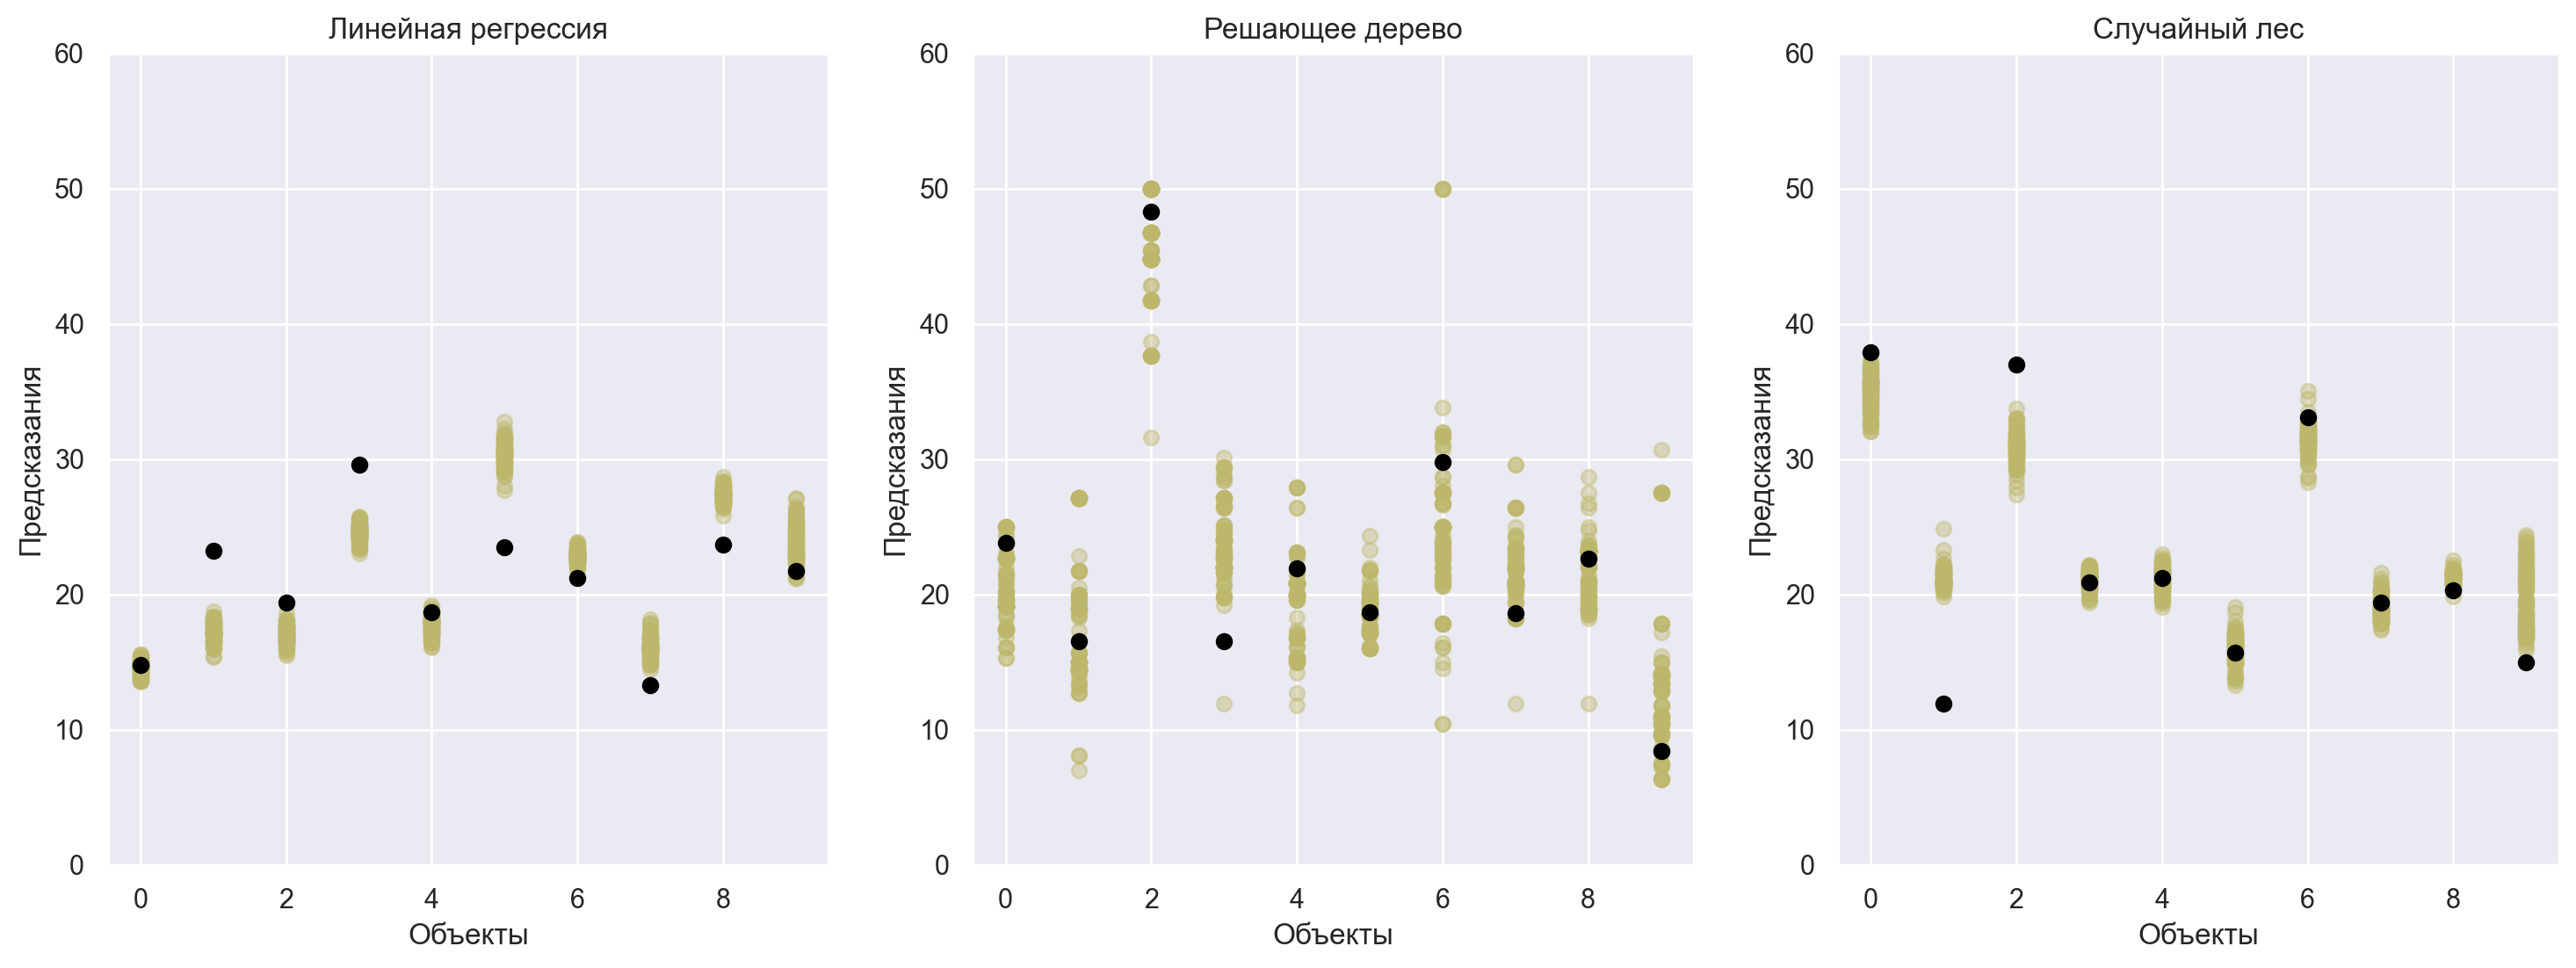

In [17]:
fig = plt.figure(figsize=(18, 6))

plt.subplot(1,3,1)
plot_predictions(LinearRegression(), X, y, title='Линейная регрессия')

plt.subplot(1,3,2)
plot_predictions(DecisionTreeRegressor(), X, y, title='Решающее дерево')

plt.subplot(1,3,3)
plot_predictions(RandomForestRegressor(n_jobs=-1), X, y, title='Случайный лес')


__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__ Эти графики достаточно наглядно отражают смещение и разброс для каждого алгоритма. Смещение в данном случае это смещение черной точки от набора цветных, а разброс это длина набора цветных точек для одного объекта.   
В случае линейной регрессии видим, что смещение набора предсказаний(точки цвета хаки) смещено относительно реальных объектов(черных точек), но при этом разброс для одного объекта небольшой. Для дерева смещение небольшое, так как черные точки попадают в набор предсказаний, но при этом разброс у одного объекта может быть очень большой. Ну и для леса как мы видели ранее, смещение небольшое как у дерева и разброс также небольшой как у линеной регрессии

$\color{red}{\text{Комментарий от проверяющего:}}$

**Балл:** 1.0

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

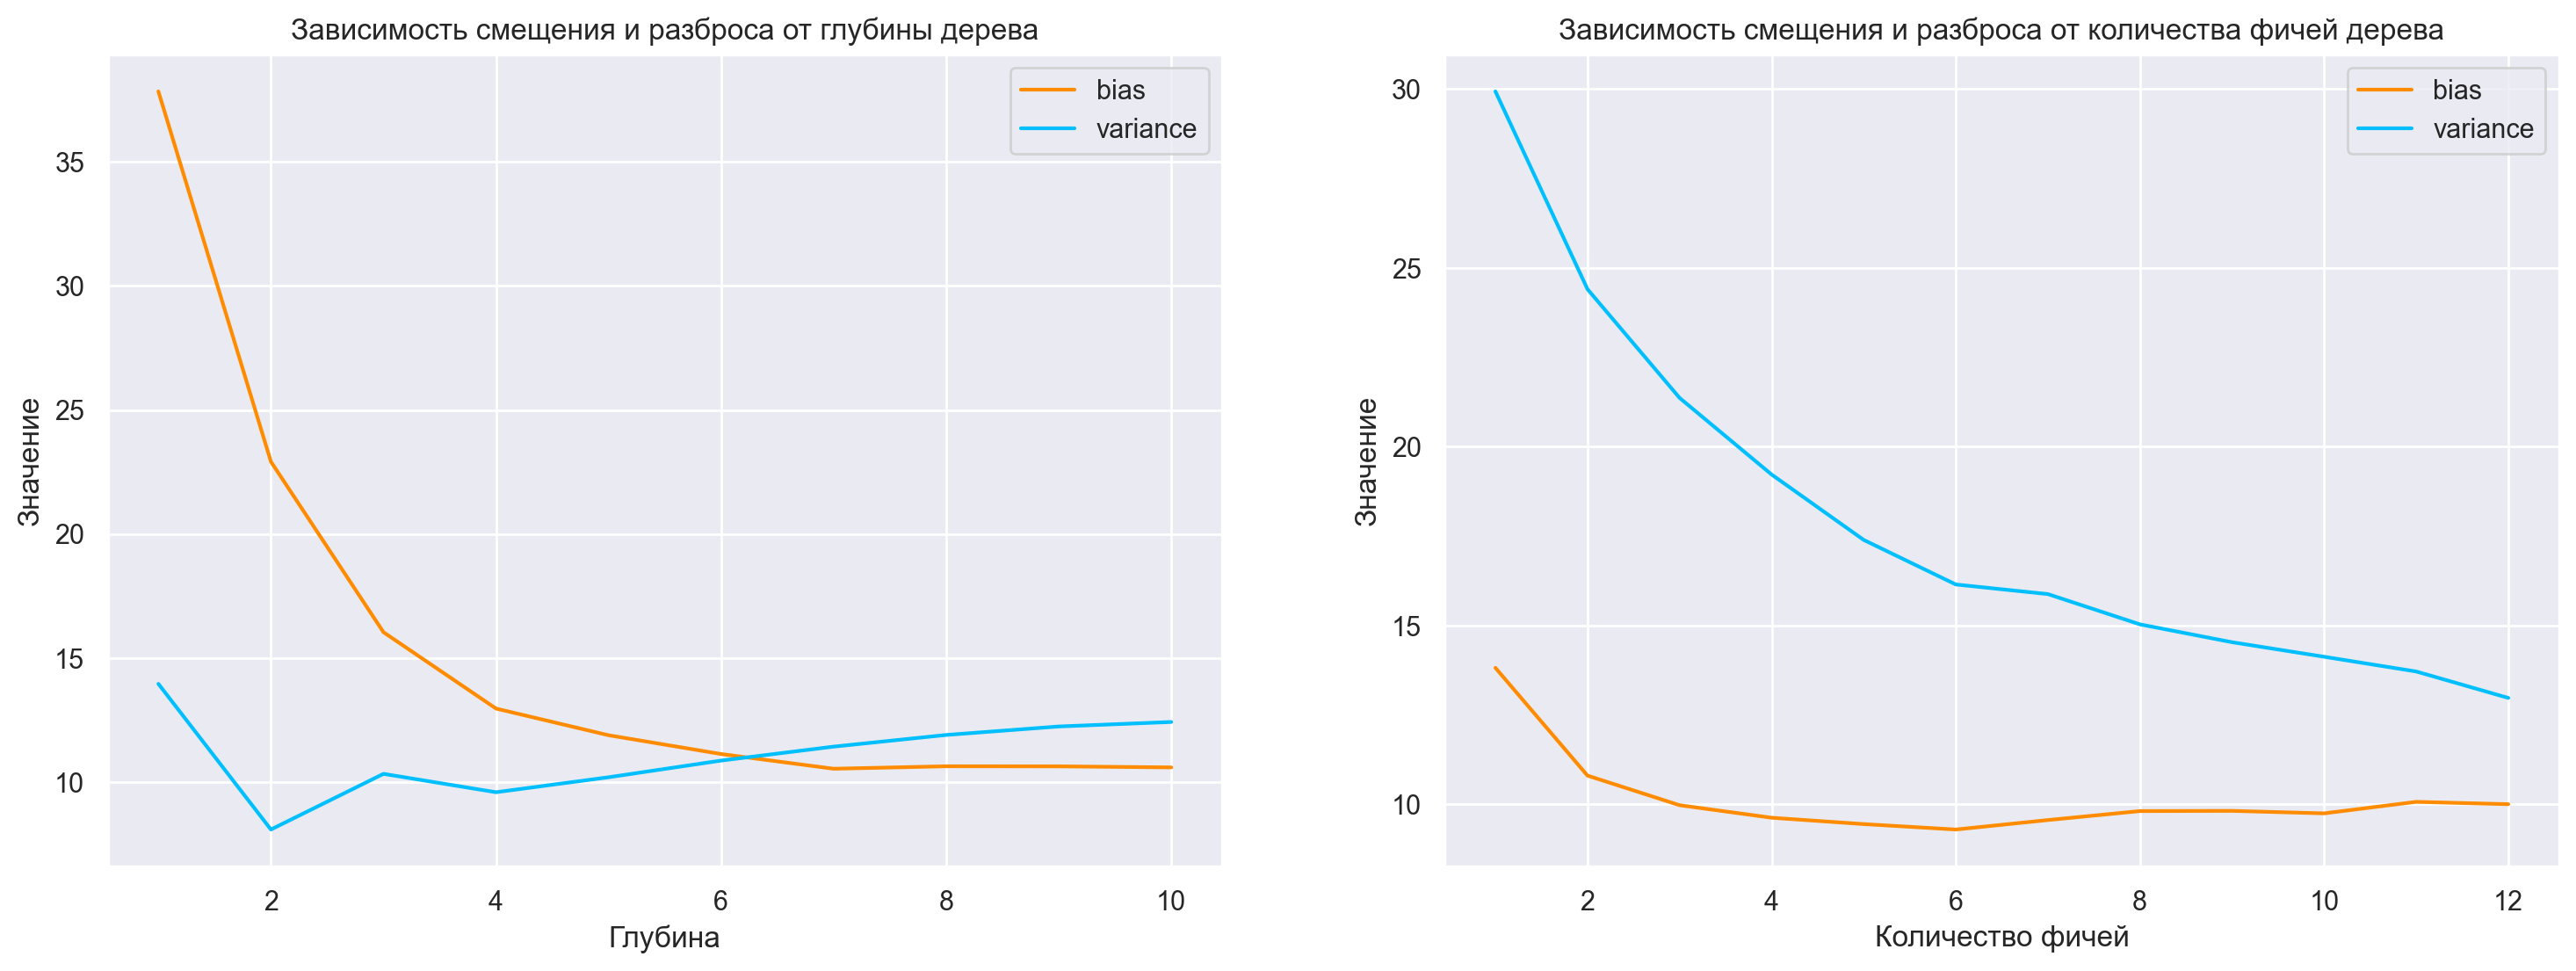

In [26]:
max_depth = np.arange(1, 11)
max_features = np.arange(1, X.shape[1])
depth_bias = []
depth_variance = []
features_bias = []
features_variance = []

for depth in max_depth:
    bias, variance, error = compute_biase_variance(DecisionTreeRegressor(max_depth=depth), X, y)
    depth_bias.append(bias)
    depth_variance.append(variance)

fig = plt.figure(figsize=(18, 6))

plt.subplot(1,2,1)
plt.plot(max_depth, depth_bias, c='darkorange', label='bias')
plt.plot(max_depth, depth_variance, c='deepskyblue', label='variance')
plt.legend()
plt.xlabel('Глубина')
plt.ylabel('Значение')
plt.title('Зависимость смещения и разброса от глубины дерева')

for feature in max_features:
    bias, variance, error = compute_biase_variance(DecisionTreeRegressor(max_features=feature), X, y)
    features_bias.append(bias)
    features_variance.append(variance)

plt.subplot(1,2,2)
plt.plot(max_features, features_bias, c='darkorange', label='bias')
plt.plot(max_features, features_variance, c='deepskyblue', label='variance')
plt.legend()
plt.xlabel('Количество фичей')
plt.ylabel('Значение')
plt.title('Зависимость смещения и разброса от количества фичей дерева')

plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [27]:
from sklearn.ensemble import GradientBoostingRegressor

Text(0.5, 1.0, 'Зависимость смещения и разброса от количества моделей в градиентном бустинге')

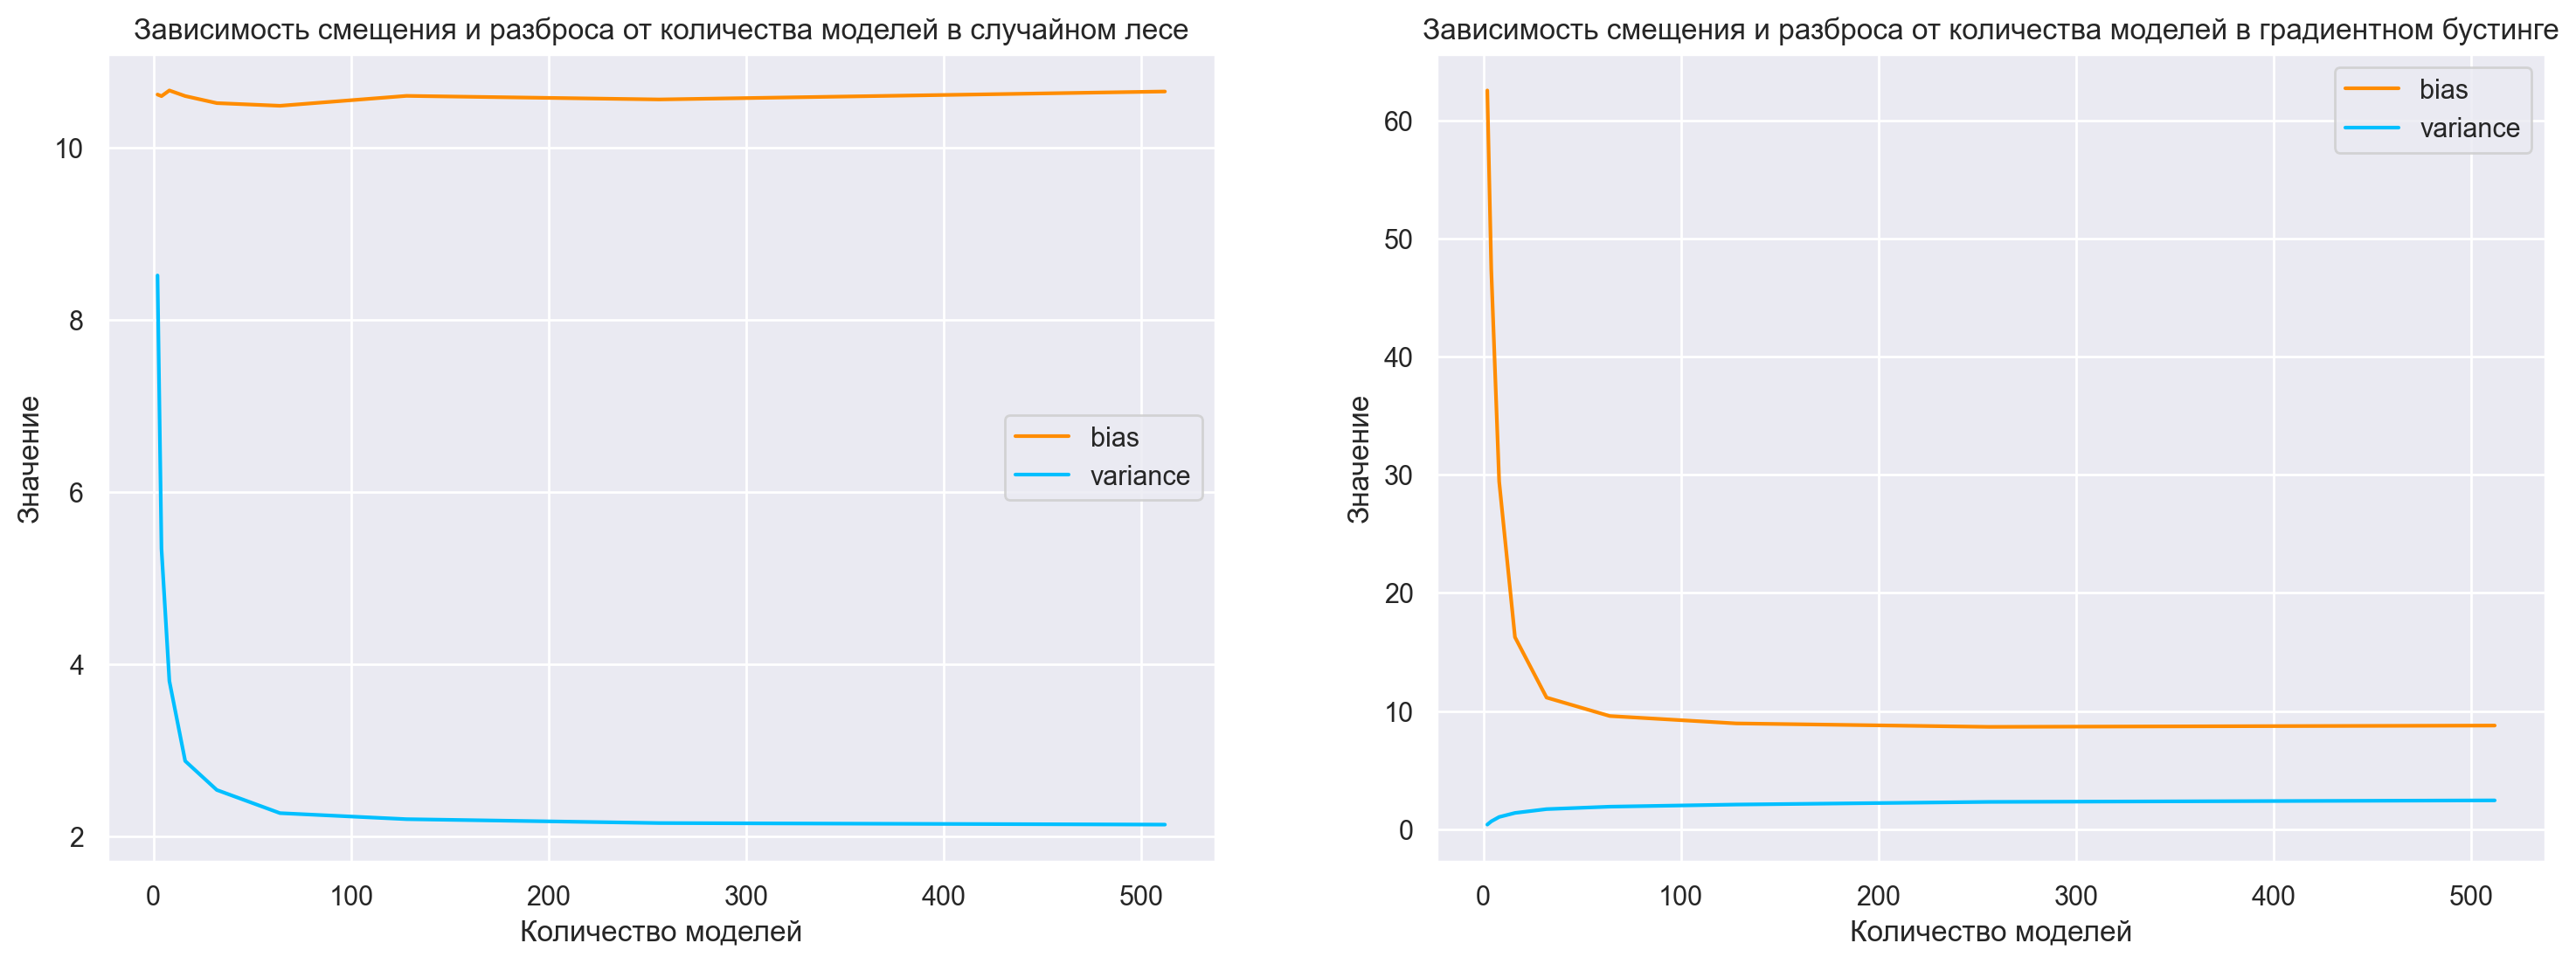

In [30]:
forest_bias, forest_variance, boosting_bias, boosting_variance = [], [], [], []
n_estimators = 2**np.arange(1,10)

for estimators in n_estimators:
    bias, variance, error = compute_biase_variance(RandomForestRegressor(n_estimators=estimators, n_jobs=-1), X, y)
    forest_bias.append(bias)
    forest_variance.append(variance)

fig = plt.figure(figsize=(18, 6))

plt.subplot(1,2,1)
plt.plot(n_estimators, forest_bias, c='darkorange', label='bias')
plt.plot(n_estimators, forest_variance, c='deepskyblue', label='variance')
plt.legend()
plt.xlabel('Количество моделей')
plt.ylabel('Значение')
plt.title('Зависимость смещения и разброса от количества моделей в случайном лесе')  

for estimators in n_estimators:
    bias, variance, error = compute_biase_variance(GradientBoostingRegressor(n_estimators=estimators), X, y)
    boosting_bias.append(bias)
    boosting_variance.append(variance)

plt.subplot(1,2,2)
plt.plot(n_estimators, boosting_bias, c='darkorange', label='bias')
plt.plot(n_estimators, boosting_variance, c='deepskyblue', label='variance')
plt.legend()
plt.xlabel('Количество моделей')
plt.ylabel('Значение')
plt.title('Зависимость смещения и разброса от количества моделей в градиентном бустинге')
plt.show()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

**Рассмотрим первый график с зависимостью от глубины дерева**

Видим, что с увеличением глубины смещение уменьшается. Это логично, так как чем больше глубина, тем более сложное дерево получается и тем точнее оно отображает реальную зависимость в данных. У разброса нет какого-то планомерного изменения, потому что в целом любое дерево чувствительно к изменениям в данных, что глубокое что не глубокое. Но оптимальными значениями для разброса являются 2 и 4, а дальше с увеличением глубины разброс немного увеличивается. 

**Второй график с зависимостью от максимального количества фичей**

Смещение уменьшается только для первых трех значений. То есть при маленьком количестве фичей дерево не до конца подстраивается под выборку и не совсем точно отображает реальную зависимость. А уже при дальнейшем увеличении фичей с учетом, что у нас максимально глубокое дерево перебираются уже все возможные наборы фичей и смещение остается на одном уровне. Граница выхода на константу зависит от количества признаков в нашей выборке. В нашем датасете 13 признаков и начиная с 4 фичей дерево уже хорошо описывает данные. Разброс же уменьшается на всем наборе фичей. Кажется, это происходит потому, что чем больше мы берем фичей, тем меньше дерево будет меняться при небольших изменениях в данных

**Третий график с количеством моделей в случайном лесе**

Тут все достаточно просто. Мы уже знаем, что бэггинг над деревьями не увеличивает(да и в целом не уменьшает) смещение базового алгоритма. Лес по сути и есть бэггинг над деревьями, поэтому смещение при изменении числа моделей в ансамбле не меняется. А вот разброс, наоборот, сильно уменьшается при бэггинге. В лучшем случае в N раз при независимости моделей, иначе чуть меньше. Это мы и видим - разброс сильно уменьшается с увеличением числа моделей в лесе и дальше выходит на плато

**Четвертый график с количеством моделей в градиентном бустинге**

Здесь картина обратная по сравнению с лесом. В бустинге базовые модели берутся простые, поэтому в отдельности каждая из них плохо описывает реальную зависимость в данных, поэтому в случае малого числа моделей смещение большое, а по мере увеличения числа моделей смещение уменьшается, так как бустинг лучше подстраивается под выборку. Разброс немного увеличивается с ростом числа моделей, потому что каждая новая модель берется с небольшим весом и не сильно вносит вклад в разброс

$\color{red}{\text{Комментарий от проверяющего:}}$

**Балл:** 2.0

__11. Бонус (0.1 балла)__


Прикрепите фотографию того, как вы начали эту зиму ❄️

__Your answer here:__ Обустроил рабочее место 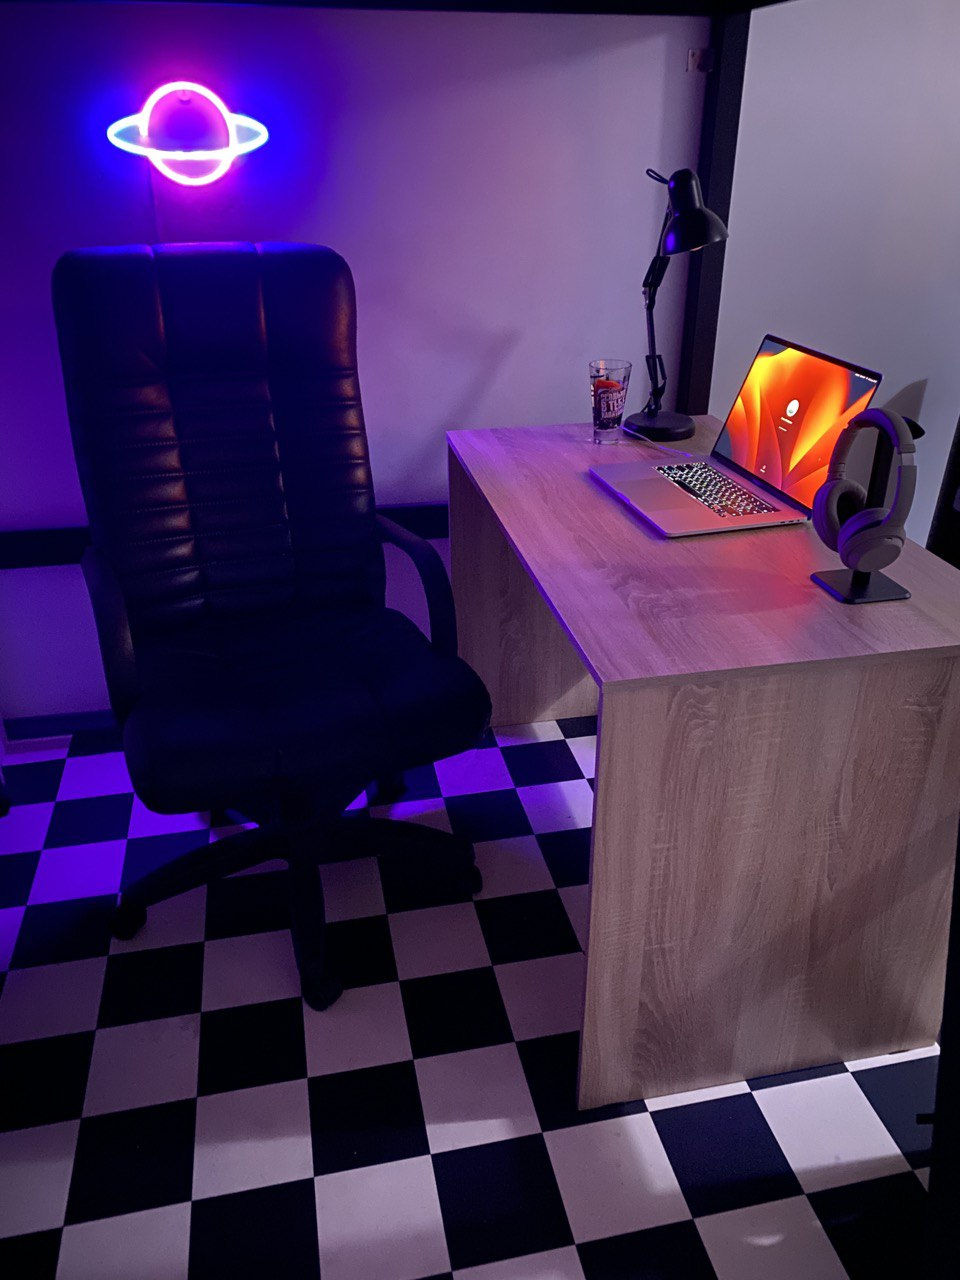

$\color{red}{\text{Комментарий от проверяющего:}}$

**Балл:** 0.01